# 中值滤波

In [1]:
import numpy as np
import cupy as cp
import cv2
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel(src,kname):
    _ = cp.zeros((1,)) # 初始化cuda context
    kernel = cp.core.core.compile_with_cache(src).get_function(kname)
    return kernel

In [48]:
sources = string.Template("""
extern "C"{
 __device__ const int BLOCKDIM = 32;
 __device__ const int MAX_WINDOW = 11;
 
 __device__ const int FILTER_SIZE = 9;
__device__ const int FILTER_HALFSIZE = FILTER_SIZE >> 1;

__device__ void sort_quick(float *x, int left_idx, int right_idx) 
{
      int i = left_idx, j = right_idx;
      float pivot = x[(left_idx + right_idx) / 2];
      while (i <= j) 
      {
            while (x[i] < pivot)
                  i++;
            while (x[j] > pivot)
                  j--;
            if (i <= j) {
                 float temp;
                  temp = x[i];
                  x[i] = x[j];
                  x[j] = temp;
                  i++;
                  j--;
            }
      };
      if (left_idx < j)
            sort_quick(x, left_idx, j);
      if (i < right_idx)
            sort_quick(x, i, right_idx);
}

__device__ void sort_bubble(float *x, int n_size) 
{
    for (int i = 0; i < n_size - 1; i++) 
    {
        for(int j = 0; j < n_size - i - 1; j++) 
        {
            if (x[j] > x[j+1]) 
            {
                float temp = x[j];
                x[j] = x[j+1];
                x[j+1] = temp;
            }
        }
    }
}
__device__ void sort_linear(float *x, int n_size) 
{
    for (int i = 0; i < n_size-1; i++) 
    {
        int min_idx = i;
        for (int j = i + 1; j < n_size; j++) 
        {
            if(x[j] < x[min_idx])
            min_idx = j;
        }
        float temp = x[min_idx];
        x[min_idx] = x[i];
        x[i] = temp;
    }
}

__device__ int index(int x, int y, int width) 
{
    return (y * width) + x;
}

__device__ int clamp(int value, int bound) 
{
    if (value < 0) {
        return 1;
    }
    if (value < bound) {
        return value;
    }
    return bound - 1;
}


__global__ void median_filter_2d(unsigned char* input, unsigned char* output, int width, int height)
{
    const int x = blockIdx.x * blockDim.x + threadIdx.x;
    const int y = blockIdx.y * blockDim.y + threadIdx.y;

    if((x<width) && (y<height))
    {
        const int color_tid = index(x,y,width);
        float windowMedian[MAX_WINDOW*MAX_WINDOW];
        int windowElements = 0;
        for (int x_iter = x - FILTER_HALFSIZE; x_iter <= x + FILTER_HALFSIZE; x_iter ++)
         {
            for (int y_iter = y - FILTER_HALFSIZE; y_iter <= y + FILTER_HALFSIZE; y_iter++)
             {
                if (0<=x_iter && x_iter < width && 0 <= y_iter && y_iter < height)
                {
                    windowMedian[windowElements++] = input[index(x_iter,y_iter,width)];
                }
            }
        }
        sort_bubble(windowMedian,windowElements);
        //sort_linear(windowMedian,windowElements);
        //sort_quick(windowMedian,0,windowElements);
        output[color_tid] = windowMedian[windowElements/2];
    }
}

__global__ void median_filter_2d_sm(unsigned char* input, unsigned char* output, int width, int height)
{
    __shared__ int sharedPixels[BLOCKDIM + FILTER_SIZE][BLOCKDIM + FILTER_SIZE];

    const int x = blockIdx.x * blockDim.x + threadIdx.x;
    const int y = blockIdx.y * blockDim.y + threadIdx.y;

    int xBlockLimit_max = blockDim.x - FILTER_HALFSIZE - 1;
    int yBlockLimit_max = blockDim.y - FILTER_HALFSIZE - 1;
    int xBlockLimit_min = FILTER_HALFSIZE;
    int yBlockLimit_min = FILTER_HALFSIZE;

    if (threadIdx.x > xBlockLimit_max && threadIdx.y > yBlockLimit_max) {
        int i = index(clamp(x + FILTER_HALFSIZE,width), clamp(y + FILTER_HALFSIZE,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x + 2*FILTER_HALFSIZE][threadIdx.y + 2*FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.x > xBlockLimit_max && threadIdx.y < yBlockLimit_min) {
        int i = index(clamp(x + FILTER_HALFSIZE,width), clamp(y - FILTER_HALFSIZE,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x + 2*FILTER_HALFSIZE][threadIdx.y] = pixel;
    }
    if (threadIdx.x < xBlockLimit_min && threadIdx.y > yBlockLimit_max) {
        int i = index(clamp(x - FILTER_HALFSIZE,width), clamp(y + FILTER_HALFSIZE,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x][threadIdx.y + 2*FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.x < xBlockLimit_min && threadIdx.y < yBlockLimit_min) {
        int i = index(clamp(x - FILTER_HALFSIZE,width), clamp(y - FILTER_HALFSIZE,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x][threadIdx.y] = pixel;
    }
    if (threadIdx.x < xBlockLimit_min) {
        int i = index(clamp(x - FILTER_HALFSIZE,width), clamp(y,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x][threadIdx.y + FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.x > xBlockLimit_max) {
        int i = index(clamp(x + FILTER_HALFSIZE,width), clamp(y,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x + 2*FILTER_HALFSIZE][threadIdx.y + FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.y < yBlockLimit_min) {
        int i = index(clamp(x,width), clamp(y - FILTER_HALFSIZE,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x + FILTER_HALFSIZE][threadIdx.y] = pixel;
    }
    if (threadIdx.y > yBlockLimit_max) {
        int i = index(clamp(x,width), clamp(y + FILTER_HALFSIZE,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x + FILTER_HALFSIZE][threadIdx.y + 2*FILTER_HALFSIZE] = pixel;
    }
    int i = index(x, y, width);
    unsigned int pixel = input[i];
    sharedPixels[threadIdx.x + FILTER_HALFSIZE][threadIdx.y + FILTER_HALFSIZE] = pixel;

    __syncthreads();

    if((x<width) && (y<height))
    {
        const int color_tid = y * width + x;
        float windowMedian[MAX_WINDOW*MAX_WINDOW];
        int windowElements = 0;

        for (int x_iter = 0; x_iter < FILTER_SIZE; x_iter ++) 
        {
            for (int y_iter = 0; y_iter < FILTER_SIZE; y_iter++) 
            {
                if (0<=x_iter && x_iter < width && 0 <= y_iter && y_iter < height) 
                {
                    windowMedian[windowElements++] = sharedPixels[threadIdx.x + x_iter][threadIdx.y + y_iter];
                }
            }
        }
        sort_bubble(windowMedian,windowElements);
        //sort_linear(windowMedian,windowElements);
        //sort_quick(windowMedian,0,windowElements);
        output[color_tid] = windowMedian[windowElements/2];
    }
}

}
""").substitute()

In [46]:
src = cv2.imread('../../datas/f2.jpg',0)

In [49]:
median_filter_2d = load_kernel(sources,'median_filter_2d_sm')

In [50]:
height,width = src.shape
BLOCKDIM = 32
sigma1 = 50
sigma2 = 50
dim_block = (32,32)
grid = ((dim_block[0] + width - 1) // dim_block[0],
        (dim_block[1] + height - 1) // dim_block[1])
src_cu = cp.asarray(src).astype(cp.uint8)
dst_cu = cp.zeros(src.shape,dtype=cp.uint8)

In [51]:
median_filter_2d(grid=grid,block=dim_block,args=(src_cu,dst_cu,width,height))

In [52]:
dst = dst_cu.get()
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = np.uint8(np.abs(dst))

([], <a list of 0 Text yticklabel objects>)

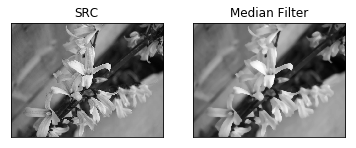

In [53]:
plt.subplot(121)
plt.imshow(src,'gray')
plt.title('SRC')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

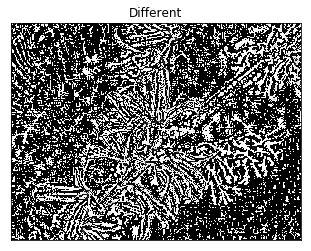

In [54]:
plt.imshow(np.abs(dst - src),'gray')
plt.title('Different')
plt.xticks([])
plt.yticks([])